In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from sklearn.metrics import mean_squared_error
import math

In [9]:
# Folder paths
input_folder = r'C:\Users\anand\Code_basics\GDA\GDA_Project\GDA_Final\Raichur'
output_folder = r'C:\Users\anand\Code_basics\GDA\GDA_Project\GDA_Final\LSTM_Plots'

rmse_file = os.path.join(output_folder, 'rmse_results.txt')

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [ ]:
def create_dataset(dataset, time_step=10):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
with open(rmse_file, 'a') as f:
    f.write("File, Train RMSE, Test RMSE\n")  

    for filename in os.listdir(input_folder):
        if filename.endswith('.csv'):
            print(f"Processing {filename}...")

            df = pd.read_csv(os.path.join(input_folder, filename))
            dates = pd.to_datetime(df['date'], format='%Y-%m-%d')  
            df1 = df['NDVI'] 

            scaler = MinMaxScaler(feature_range=(0, 1))
            df1_scaled = scaler.fit_transform(np.array(df1).reshape(-1, 1))

            training_size = int(len(df1_scaled) * 0.85)
            test_size = len(df1_scaled) - training_size
            train_data, test_data = df1_scaled[0:training_size, :], df1_scaled[training_size:len(df1_scaled), :]

            time_step = 10
            X_train, y_train = create_dataset(train_data, time_step)
            X_test, y_test = create_dataset(test_data, time_step)

            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

            model = Sequential()

            model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(10, 1)))
            model.add(Dropout(0.2))

            model.add(Bidirectional(LSTM(64, return_sequences=True)))
            model.add(Dropout(0.2))

            model.add(Bidirectional(LSTM(64)))
            model.add(Dropout(0.2))

            model.add(Dense(1))

            model.compile(loss='mean_squared_error', optimizer='adam')

            model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

            train_predict = model.predict(X_train)
            test_predict = model.predict(X_test)

            train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
            test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))

            print(f"Train RMSE: {train_rmse}")
            print(f"Test RMSE: {test_rmse}")

            with open(rmse_file, 'a') as f:
                f.write(f"{filename}, {train_rmse}, {test_rmse}\n")

            look_back = 10
            trainPredictPlot = np.empty_like(df1_scaled)
            trainPredictPlot[:, :] = np.nan
            trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

            testPredictPlot = np.empty_like(df1_scaled)
            testPredictPlot[:, :] = np.nan
            testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1_scaled)-1, :] = test_predict

            plt.figure(figsize=(12, 6))

            plt.plot(dates, scaler.inverse_transform(df1_scaled), label='Original Data', color='blue', linewidth=1)

            plt.plot(dates[:len(trainPredictPlot)], scaler.inverse_transform(trainPredictPlot), label='Training Predictions', color='green', linestyle='--', linewidth=1)

            plt.plot(dates, scaler.inverse_transform(testPredictPlot), label='Test Predictions', color='red', linestyle='--', linewidth=1)

            plt.title(f'Time Series Predictions - {filename}')
            plt.xlabel('Date')
            plt.ylabel('NDVI Value')
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)

            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # '%b' for month name, '%Y' for year
            plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Set major ticks every 3 months

            plt.xticks(rotation=45)

            plt.tight_layout()
            plt.savefig(os.path.join(output_folder, f'LSTM_Plot_{filename}.png'))
            plt.close()

print("Processing complete. Plots saved in 'LSTM_Plots' and RMSE results saved in 'rmse_results.txt'.")


2/2 [==============================] - 0s 6ms/step
Train RMSE: 0.11033182334465312
Test RMSE: 0.14268916153654893
Processing data_16.07_76.81.csv...
Epoch 1/100
4/4 [==============================] - 16s 1s/step - loss: 0.1211 - val_loss: 0.0559
Epoch 2/100
4/4 [==============================] - 0s 40ms/step - loss: 0.0589 - val_loss: 0.0458
Epoch 3/100
4/4 [==============================] - 0s 48ms/step - loss: 0.0375 - val_loss: 0.0721
Epoch 4/100
4/4 [==============================] - 0s 45ms/step - loss: 0.0446 - val_loss: 0.0537
Epoch 5/100
4/4 [==============================] - 0s 49ms/step - loss: 0.0342 - val_loss: 0.0437
Epoch 6/100
4/4 [==============================] - 0s 59ms/step - loss: 0.0361 - val_loss: 0.0427
Epoch 7/100
4/4 [==============================] - 0s 46ms/step - loss: 0.0330 - val_loss: 0.0484
Epoch 8/100
4/4 [==============================] - 0s 49ms/step - loss: 0.0327 - val_loss: 0.0495
Epoch 9/100
4/4 [==============================] - 0s 48ms/step - lo

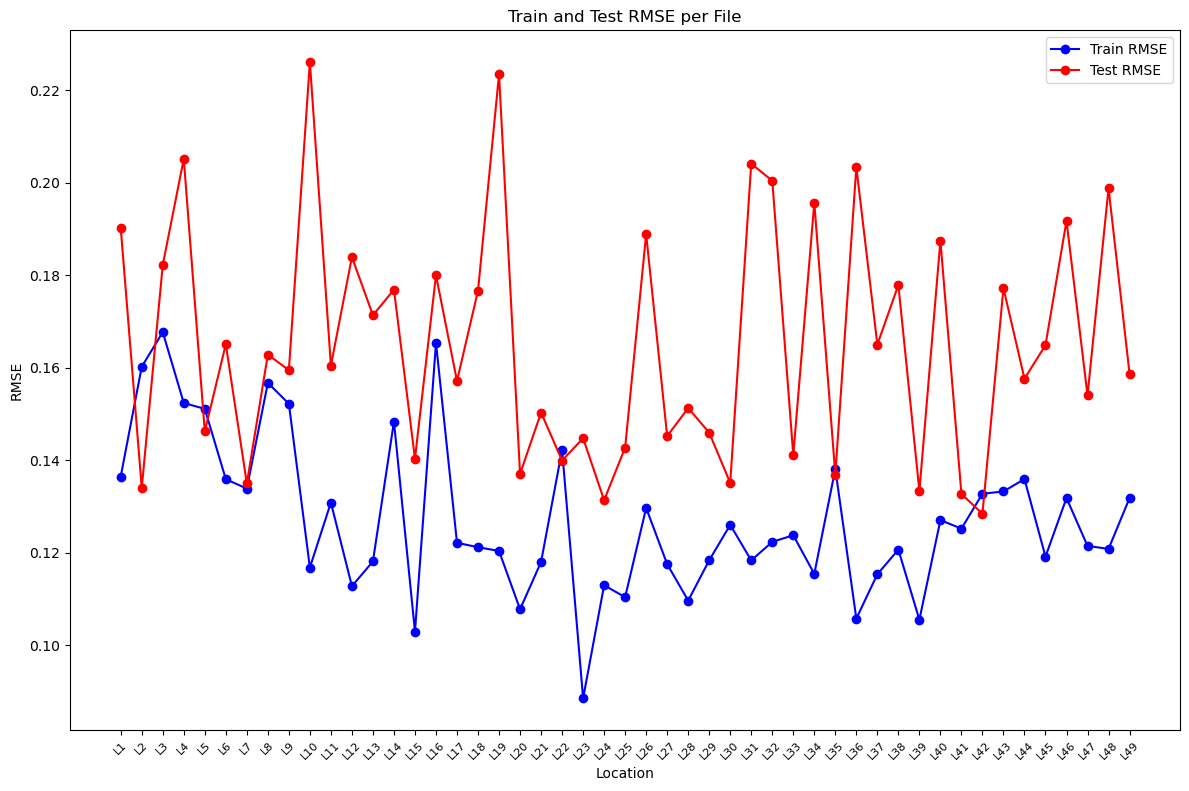

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
data = {
    'File': [f"L{i+1}" for i in range(49)],
    'Train RMSE': [
        0.13643270175240274, 0.16017065530456068, 0.16767069054222755, 0.15233223965155995, 
        0.15106824913284173, 0.13585601020657775, 0.13382480242318104, 0.15668668184254556, 
        0.15217442402746842, 0.11675679438771451, 0.13080496720454032, 0.11271829868254049, 
        0.11807983813334247, 0.14832279533099235, 0.10288278436710814, 0.16535449778621494, 
        0.12209380911638774, 0.12115077644330267, 0.12033298178096899, 0.10772003016797906, 
        0.11795932753787358, 0.14221043064012728, 0.08844352692159702, 0.11293058323855852, 
        0.11033182334465312, 0.12964539443016684, 0.11748131703885463, 0.10960037089941925, 
        0.11831702872568071, 0.12598610372154584, 0.11829678570948891, 0.12230032934708494, 
        0.1237289844076152, 0.11537224986764168, 0.13807143106522476, 0.10570870193879933, 
        0.11529982967007696, 0.12062616854546557, 0.10546056279386537, 0.1270114578867917, 
        0.12516220595878505, 0.13271979663400732, 0.1331988685348864, 0.1358840449552181, 
        0.11910701230215148, 0.1317858235475327, 0.12141820907266578, 0.12078609398612863, 
        0.13177535748617236
    ],
    'Test RMSE': [
        0.19022384234159287, 0.1339725947394486, 0.18216272794673, 0.20514010609385044, 
        0.14620027010181894, 0.16504681784165878, 0.13493362173887286, 0.1627994595053761, 
        0.15943655801772574, 0.22607034325125186, 0.16042509586124412, 0.18389589667561718, 
        0.17130617065690001, 0.1768559147229129, 0.14027473622722592, 0.17996627518968442, 
        0.1570959122180391, 0.17663492575461842, 0.2234321538363331, 0.13699447563812545, 
        0.1502582896725279, 0.13988779909085325, 0.1447129759745921, 0.13130764512824875, 
        0.14268916153654893, 0.1888584355512659, 0.14517893046314304, 0.15123703780517636, 
        0.1459180160057758, 0.13504684459083055, 0.20408187662423719, 0.20040573503356499, 
        0.1410807040499791, 0.19563146369884313, 0.13682795421810523, 0.20335743391897607, 
        0.16498523390503633, 0.17785393463316704, 0.13330177255967718, 0.18744234021987252, 
        0.1326797475351434, 0.12836720905509075, 0.17718249596085275, 0.15758328380940995, 
        0.16484854877767774, 0.19172197433238652, 0.15397583066857035, 0.19880227276124615, 
        0.15865265497540032
    ]
}
labels = [f"Loc{i+1}" for i in range(len(data['File']))]


df = pd.DataFrame(data)

plt.figure(figsize=(12, 8))
plt.plot(df['File'], df['Train RMSE'], label='Train RMSE', color='blue', marker='o')
plt.plot(df['File'], df['Test RMSE'], label='Test RMSE', color='red', marker='o')
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Location')
plt.ylabel('RMSE')
plt.title('Train and Test RMSE per File')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()
